# Text Mining for Economics and Finance: Homework 1

## Roger Garriga Calleja, Javier Mas Adell, José Fernando Moreno Gutiérrez

Data: Speech_data_extended.txt found on https://github.com/sekhansen/text-mining-tutorial.

### Exercise 1: Pre-processing the data
Packages used:

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
import sklearn

We will work with data from 1900 onwards to make the data more manageable. However, the same process could be used in the whole dataset. The data we are using corresponds to the speeches made by the different presidents of United States. Each row is a speech and it contains three columns: The president, the speech and the year.

In [ ]:
#Import the dataset.
data = pd.read_table("speech_data_extend.txt", encoding="utf-8")
data = data.loc[data['year']>=1900]
data = data.reset_index()

We need to pre-process the data in order to analyse it. There are four steps:
- Tokenization (separate single words/tokens by spaces).
- Removal of non-alphabetical characters.
- Removal of stopwords (words that do not help diferenciate documents such as 'a', 'the', 'for', etc.).
- Stemming (remove suffixes).

In [ ]:
#Tokenization
prep_data = data.apply(lambda row: nltk.word_tokenize(row['speech'].lower()), axis=1)

#Removal of stop words and non-alphanumeric characters
stop_w=set(stopwords.words('english'))
for i in range(len(prep_data)):
    prep_data[i] = [w for w in prep_data[i] if w not in stop_w and w.isalpha()] 

#Stemming
stemmer = PorterStemmer() #Create a stemmer object
for i in range(len(prep_data)):
    prep_data[i] = [stemmer.stem(elem) for elem in prep_data[i]]

Next step is to create an tf-idf score for each word in the corpus and eliminate those that are below a certain threshold. In this case we chose to keep 10% of the words.

In [ ]:
unique_words = np.unique([word for doc in prep_data for word in doc])
num_words_cutoff = round(0.1*len(unique_words))

#Stemmer
def stem(tokens,stemmer):
    stems = [stemmer.stem(token) for token in tokens]
    return stems

#Tokenizer
def tokenizer(doc):
    stemmer = PorterStemmer()
    tokens = nltk.word_tokenize(doc.lower())
    tokens = [w for w in tokens if w not in stop_w and w.isalpha()]
    stems = stem(tokens,stemmer)
    return stems
#tfidfmat
vectorizer = TfidfVectorizer(tokenizer = tokenizer, max_features = num_words_cutoff) #Create a tfidf object
tfidfmat = vectorizer.fit_transform(data['speech'])

tfidfmat = tfidfmat.toarray()

### Exercise 2: Dictionary Analysis
Packages used:

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

path = "/home/chpmoreno//Dropbox/Documents/BGSE/Third_Term/TMSC/homeworks/hw1/github/Text-Mining/hw1"

We used Harvard IV dictionary (http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm) as our baseline for the exercise. In particular we generated two functions. The first one (positive_negative_index) take into account two dictionaries, one for positive words and one for negative. The second one (selected_dict_index) can take any Harvard IV dictionary (our example uses "Hostile" dictionary). As quantitative representation we used:

* positive_negative_index: (positive words in the document - negative words in the document) / total words in the documents

* selected_dict_index: selected words in the document / total words in the documents

We add an input for each value for term weighting computation.

Then we compare our quantitative representation with the annual GDP growth, inflation and maximum recession probability. The data was taken from Federal Reserve FRED data (https://fred.stlouisfed.org/).

The following is the code used:

In [ ]:
data = pd.read_table(path+"/speech_data_extend.txt", encoding="utf-8")
dictionary = pd.read_excel(path+"/inquireraugmented.xls")
economic_variables = pd.read_excel(path+"/economicdata.xls").set_index(['year'])

#tf-idf the data

def stem(tokens,stemmer):
    stems = [stemmer.stem(token) for token in tokens]
    return stems

def tokenizer(doc):
    stop_w = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    tokens = nltk.word_tokenize(doc.lower())
    tokens = [w for w in tokens if w not in stop_w and w.isalpha()]
    stems = stem(tokens,stemmer)
    return stems

vectorizer = TfidfVectorizer(tokenizer = tokenizer,
                             stop_words = stopwords.words('english')) #Create a tfidf object

tfidfmat = vectorizer.fit_transform(data['speech'])

def tfidfmat_to_tables(tfidfmat):
    desc_vect = tfidfmat.tocsr()
    n_docs = desc_vect.shape[0]
    tfidftables = [{} for _ in range(n_docs)]
    terms = vectorizer.get_feature_names()
    for i, j in zip(*desc_vect.nonzero()):
        tfidftables[i][terms[j]] = tfidfmat[i, j]
    return tfidftables

def tfidfmat_to_df(tfidftable):
    temp = []
    dictlist = []
    for key, value in tfidftable.items():
        temp = [key,value]
        dictlist.append(temp)
    df_temp = pd.DataFrame(dictlist)
    return df_temp

tfidftables = tfidfmat_to_tables(tfidfmat)

def positive_negative_index(tfidfdf, dictionary, positive_words, negative_words, weighted = False):
    if weighted == False:
        index = (sum(tfidfdf.isin(positive_words)[0]) - sum(tfidfdf.isin(negative_words)[0])) / tfidfdf.shape[0]
    else:
        index = (sum(tfidfdf[1][tfidfdf.isin(positive_words)[0]]) - sum(tfidfdf[1][tfidfdf.isin(negative_words)[0]])) / sum(tfidfdf[1])
    return index


def selected_dict_index(tfidfdf, dictionary, words, weighted = False):
    if weighted == False:
        index = sum(tfidfdf.isin(words)[0]) / tfidfdf.shape[0]
    else:
        index = sum(tfidfdf[1][tfidfdf.isin(words)[0]]) / sum(tfidfdf[1])
    return index

stemmer = PorterStemmer()

positive_words = set(stem(dictionary.filter(items = ["Entry", "Positiv"]).dropna(axis = 0)['Entry'].str.lower().astype(str), stemmer))
negative_words = set(stem(dictionary.filter(items = ["Entry", "Negative"]).dropna(axis = 0)['Entry'].str.lower().astype(str), stemmer))

selection = "Hostile"
words = set(stem(dictionary.filter(items = ["Entry", selection]).dropna(axis = 0)['Entry'].str.lower().astype(str), stemmer))

positive_negative_indicator = []
selection_indicator = []
positive_negative_indicator_weighted = []
selection_indicator_weighted = []

for i in range(tfidfmat.shape[0]):
    if len(tfidftables[i]) != 0:
        positive_negative_indicator.append(positive_negative_index(tfidfmat_to_df(tfidftables[i]), dictionary, positive_words, negative_words))
        selection_indicator.append(selected_dict_index(tfidfmat_to_df(tfidftables[i]), dictionary, words))
        positive_negative_indicator_weighted.append(positive_negative_index(tfidfmat_to_df(tfidftables[i]), dictionary, positive_words, negative_words, True))
        selection_indicator_weighted.append(selected_dict_index(tfidfmat_to_df(tfidftables[i]), dictionary, words, True))
    else:
        positive_negative_indicator.append(0)
        selection_indicator.append(0)
        positive_negative_indicator_weighted.append(0)
        selection_indicator_weighted.append(0)

data['pn'] = positive_negative_indicator
data['sel'] = selection_indicator
data['pnw'] = positive_negative_indicator_weighted
data['selw'] = selection_indicator_weighted

data_per_year = pd.concat([data.groupby(['year']).mean(), economic_variables], axis = 1)
df_norm = (data_per_year - data_per_year.mean()) / (data_per_year.max() - data_per_year.min())

In [ ]:
rho = data_per_year.corr()
pval = np.zeros([data_per_year.shape[1], data_per_year.shape[1]])
for i in range(data_per_year.shape[1]): # rows are the number of rows in the matrix.
    for j in range(data_per_year.shape[1]):
        JonI       = pd.ols(y = data_per_year.icol(i), x = data_per_year.icol(j), intercept=True)
        pval[i,j]  = JonI.f_stat['p-value']

Correlations between quatitative representations and the economic data have the expected sign in the case of positive_negative_index. For example when speeches were more positive the gdp was increasing (positive correlation) but when inflation or recession probability increased the speeches were more negative. Respect to the magnitude the correlation is stronger with inflation and recession. We perform a significance test for correlations, GDP is not significant while inflation and recession are respect to positive_negative_index. Otherwise the selected_dict_index for "Hostile" is significant for GDP. It says that presidents are more "hostiles" when they have good years in the economy. 

            pn       sel       pnw      selw       GDP  Inflation  Recession
pn    1.000000 -0.205364  0.986787 -0.188377  0.144143  -0.487930  -0.354259
sel  -0.205364  1.000000 -0.185442  0.987182  0.363728  -0.187548  -0.178773
pnw   0.986787 -0.185442  1.000000 -0.173499  0.170094  -0.534395  -0.387479
selw -0.188377  0.987182 -0.173499  1.000000  0.367874  -0.185242  -0.201115
       pn   sel   pnw  selw   GDP  Inflation  Recession
pn    0.0  0.00  0.00  0.00  0.19       0.00       0.01
sel   0.0  0.00  0.01  0.00  0.00       0.17       0.22
pnw   0.0  0.01  0.00  0.01  0.12       0.00       0.01
selw  0.0  0.00  0.01  0.00  0.00       0.18       0.17


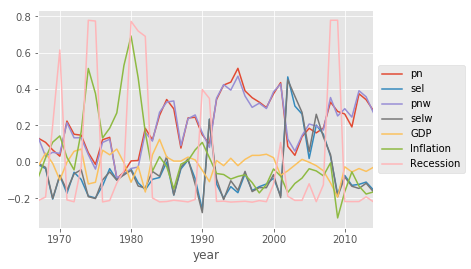

In [24]:
print(data_per_year.corr()[0:4])
print(pd.DataFrame(pval.round(2), columns = data_per_year.corr()[0:4].columns)[0:4].set_index(data_per_year.corr()[0:4].index))
df_norm.dropna().plot();
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()